# Notebook for deriving and validating a sparse model for chronic pain

We aimed at simplifying our model by reducing the number of features, as a sparse model
would be more useful in research or clinical settings. A six items model using sleep neuroticism,
mood, trauma, and anthropometric measurements (fig. 6a,b) achieved good performance in
cross-sectional data, average to good performance in longitudinal data (fig. 6c,d), and predicted
the impact of pain for the patients (fig. 6e). This represented the best trade-off between the
smallest number of features and the highest AUC-ROC, especially in the longitudinal data. This
risk score for pain was calculated by simply summing the binarized answers to the 6 items.

# Contents
1. Preparing data
2. Derive the sparse model
3. Benchmark sparse model performance
4. Evaluate discriminatory utility of sparse model
5. Sparse model associations with experience of pain
6. Plotting


In [94]:
# Import necessary packages
import numpy as np
import pandas as pd
from sklearn import linear_model, impute, feature_selection, cross_decomposition, metrics
from scipy import stats
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Set plotting defaults
col = sns.color_palette("tab10", 12)
plt.rcParams['font.size'], font = 12, 12
plt.rcParams.update({'font.family':'Arial'})

# 1. Preparing data

Here we load and organize the primary dataframes used in this notebook. Other dataframes will be loaded later on but these are necessary for foundational steps.

In [38]:
Folder = '/Users/Patty/Desktop/EVP_lab/'

# Load 99 variables used to derive the psychosocial model 
variables = pd.read_csv(Folder + '0_Variables_V3.csv')
variables = variables[variables.coding_finished==1]

# lists of variables names for both timepoint 1 and timepoint 2
variables_T0 = list((variables['Name'] + '_' + variables['T0']).values)
variables_T2 = list((variables['Name'] + '_' + variables['T2']).values)

# Load weights assigned to each variable from the psychosocial model (derived using Partial Least Squares)
W = pd.read_csv(Folder + 'Coefficients_PLSReg_3comp.csv')
variables['weights'] = W.Coefficients.values # Append weights to "variables" variable

# Load actualy variable values from each timepoint
preproc_UKB_T2 = pd.read_csv(Folder + '5_TestData_PreprocFeatures_Adv.csv')
preproc_UKB_T0 = pd.read_csv(Folder + '5_TrainData_PreprocFeatures_Adv.csv')
preproc_UKB_B = pd.read_csv(Folder + '6_BrainVisit_PreprocFeatures_Adv.csv')

# Create psychosocial model score (here termed "PLS", after the algorithmed used to derive it)
# by taking the dot product of the assigned variable weights and their actualy values at each timepoint
preproc_UKB_T2['PLS'] = np.dot(preproc_UKB_T2[variables_T0], variables['weights'])
preproc_UKB_T0['PLS'] = np.dot(preproc_UKB_T0[variables_T0], variables['weights'])
preproc_UKB_B['PLS'] = np.dot(preproc_UKB_B[variables_T2], variables['weights'])



# 2. Derive the sparse model

Here we will create a sparse version of our psychosocial model by selecting the 6 features using a data-driven feed-forward feature selection algorithm and then binarizing the features to represent the format of a clinical questionairre. 

In [31]:
## Have Original Estimator to input in forward selection (Now that we know the variables, they are no longer useful)

# Remove subjects reporting widespread pain so as not to assume its meaning in terms of number of pain sites
T0_noWP = preproc_UKB_T0[preproc_UKB_T0.WidespreadPainLastMonth_T0!=1]

# Cleaning traumas variable to not include injury to the self, which may confound prediction of chronic pain
T0_noWP['T0_noWP.IllnessInjuryStressLast2Years_T0'] = T0_noWP.IllnessInjuryStressLast2Years_T0 - T0_noWP.IllnessInjuryAssaultSelf_T0

# Create features (X) and target (y) variables
Xi = T0_noWP[variables_T0].drop(columns = ['TotalNeuroticism_T0'])
Yi = T0_noWP['NumberPainTypesLastMonth_T0']

# We will use the PLS regression model as the estimator in the sequential feature selection algorithm
plsreg = cross_decomposition.PLSRegression(n_components = 1, scale = False, max_iter=10000).fit(Xi, Yi)

# Impute missing values with median
imp_med = impute.SimpleImputer(missing_values = np.nan, strategy = 'median').fit(Raw_T0)
Raw_T0 = pd.DataFrame(data = imp_med.fit_transform(Raw_T0), columns = Raw_T0.columns)
Raw_T2 = pd.DataFrame(data = imp_med.fit_transform(Raw_T2), columns = Raw_T2.columns)

# Run sequential feature selection to derive top 15 variables
sfs_forward = feature_selection.SequentialFeatureSelector(plsreg, n_features_to_select=15, direction="forward").fit(Xi, Yi)
print(list(Xi.columns[sfs_forward.get_support()]))


/var/folders/fb/fwsj02n54bd7zmtt541bh0140000gn/T/ipykernel_40097/3017179490.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T0_noWP['T0_noWP.IllnessInjuryStressLast2Years_T0'] = T0_noWP.IllnessInjuryStressLast2Years_T0 - T0_noWP.IllnessInjuryAssaultSelf_T0


Index(['MoodSwings_T0', 'FrequencyRestlessnessLast2Weeks_T0',
       'FrequencyTirednessLast2Weeks_T0', 'SeenGPAnxietyDepression_T0',
       'RiskTaking_T0', 'IllnessInjuryStressLast2Years_T0',
       'JobManualPhysical_T0', 'IncomeHouseholdPreTax_T0',
       'PaidEmploymentSelfEmployed_T0', 'AlcoholIntakeFrequency_T0',
       'DifficultyWakingUp_T0', 'Narcolepsy_T0', 'Sleeplessness_T0',
       'GainedWeightLastYear_T0', 'BMI_T0'],
      dtype='object')

In [46]:
# Load original variable values for timepoint 1 and timepoint 2
Raw = pd.read_csv(Folder + '5_FullData_PreprocFeatures_Raw.csv')
Raw2 = pd.read_csv(Folder + '6_BrainVisit_PreprocFeatures_Raw.csv')

### Assigning binarized versions of top 6 features
Raw['Sparse_BMI'] = np.where(Raw.BMI_T0 > 30, 1, 0)
Raw2['Sparse_BMI'] = np.where(Raw2.BMI_T2 > 30, 1, 0)

# Remove injury to self from traumas variable
Raw['Sparse_Traumas'] = np.where(Raw.IllnessInjuryStressLast2Years_T0-Raw.IllnessInjuryAssaultSelf_T0 > 0, 1, 0)
Raw2['Sparse_Traumas'] = np.where(Raw2.IllnessInjuryStressLast2Years_T2-Raw2.IllnessInjuryAssaultSelf_T2 > 0, 1, 0)

# Having fed-up feelings was the most impactful feature from the neuroticism category
Raw['Sparse_Neuroticism'] = Raw['FedUpFeelings_T0']
Raw2['Sparse_Neuroticism'] = Raw2['FedUpFeelings_T2']

# Combined seeing a General Practicioner and/or Psychiatrist into one variable
Raw['Sparse_GP'] = np.where(Raw[['SeenGPAnxietyDepression_T0','SeenPsychiatristAnxietyDepression_T0']].sum(axis = 1) > 0, 1, 0)
Raw2['Sparse_GP'] = np.where(Raw2[['SeenGPAnxietyDepression_T2','SeenPsychiatristAnxietyDepression_T2']].sum(axis = 1) > 0, 1, 0)

# Cleaning coding scheme in fatigue related variables
Raw['Sparse_Tiredness'] = Raw.FrequencyTirednessLast2Weeks_T0.replace({-1: np.nan, -3: np.nan})-1
Raw2['Sparse_Tiredness'] = Raw2.FrequencyTirednessLast2Weeks_T2.replace({-1: np.nan, -3: np.nan})-1
Raw['Sparse_Sleeplessness'] = Raw.Sleeplessness_T0.replace({-3: np.nan})-1
Raw2['Sparse_Sleeplessness'] = Raw2.Sleeplessness_T2.replace({-3: np.nan})
Raw = Raw.dropna(subset = Raw.filter(like = 'Sparse').columns)
Raw2 = Raw2.dropna(subset = Raw2.filter(like = 'Sparse').columns)
Raw['Sparse_Tiredness'] = np.where(Raw.Sparse_Tiredness>0, 1, 0)
Raw2['Sparse_Tiredness'] = np.where(Raw2.Sparse_Tiredness>0, 1, 0)
Raw['Sparse_Sleeplessness'] = np.where(Raw.Sparse_Sleeplessness>1, 1, 0)
Raw2['Sparse_Sleeplessness'] = np.where(Raw2.Sparse_Sleeplessness>1, 1, 0)

# Create variables containing timepoint 0 and timepoint 2 pain variables
Pain_Cols = list(preproc_UKB_T0.filter(like='Pain').columns) + ['HeadachesLastMonth_T0', 'ChronicHeadaches_T0', 'AcuteHeadaches_T0']
Pain_Cols2 = list(preproc_UKB_B.filter(like='Pain').columns) + ['HeadachesLastMonth_T2', 'ChronicHeadaches_T2', 'AcuteHeadaches_T2']

# Filter eids
Raw_T0 = Raw[Raw.eid.isin(preproc_UKB_T0.eid)]
Raw_T2 = Raw[Raw.eid.isin(preproc_UKB_T2.eid)]
Raw_B = Raw2[Raw2.eid.isin(preproc_UKB_B.eid)]

Raw_T0 = pd.merge(Raw_T0, preproc_UKB_T0[['eid', 'PLS'] + Pain_Cols], on = 'eid', how = 'left')
Raw_T2 = pd.merge(Raw_T2, preproc_UKB_T2[['eid', 'PLS'] + Pain_Cols], on = 'eid', how = 'left')
Raw_B =  pd.merge(Raw_B, preproc_UKB_B[['eid', 'PLS'] + Pain_Cols2], on = 'eid', how = 'left')

# Derive "Sparse PLS" model using 6 binarized items
Raw_T0['Sparse_PLS'] = Raw_T0.filter(like = 'Sparse').sum(axis = 1)
Raw_T2['Sparse_PLS'] = Raw_T2.filter(like = 'Sparse').sum(axis = 1)
Raw_B['Sparse_PLS'] = Raw_B.filter(like = 'Sparse').sum(axis = 1)

# Filtering for matching eid
eid = np.intersect1d(Raw_T2.eid, Raw_B.eid)
F_Raw_T2 = Raw_T2[Raw_T2.eid.isin(eid)].sort_values(by='eid').reset_index(drop=True)
F_Raw_B = Raw_B[Raw_B.eid.isin(eid)].sort_values(by='eid').reset_index(drop=True)


## 3. Benchmarking sparse model performance
Here, we can compare the explained variance of the full model to the sparse model using number of reported pain types as the variable of interest

In [57]:
#  Subset without Pain All Over the Body
T0_noWP = Raw_T0[Raw_T0.WidespreadPainLastMonth_T0!=1]
T2_noWP = Raw_T2[Raw_T2.WidespreadPainLastMonth_T0!=1]

# Target variable
Y_T0 = T0_noWP['NumberPainTypesLastMonth_T0']
Y_T2 = T2_noWP['NumberPainTypesLastMonth_T0']

print('Cross-sectional comparison:')
print('Full model R2:',T0_noWP.PLS.corr(T0_noWP.NumberPainTypesLastMonth_T0)**2)
print('Sparse model R2:',T0_noWP.Sparse_PLS.corr(T0_noWP.NumberPainTypesLastMonth_T0)**2)
print('-----------------------------------')
print('Longitudinal comparison:')
print('Full model R2:',T2_noWP.PLS.corr(T2_noWP.NumberPainTypesLastMonth_T0)**2)
print('Sparse model R2:',T2_noWP.Sparse_PLS.corr(T2_noWP.NumberPainTypesLastMonth_T0)**2)


Cross-sectional comparison:
Full model R^2: 0.18590048844322293
Sparse model R2: 0.12058355615170356
-----------------------------------
Longitudinal comparison:
Full model R2: 0.14000024210408077
Sparse model R2: 0.09247031963985208


In [60]:
#Regression Model, Obtain RMSE for chronic and acute using sparse model
reg = linear_model.LinearRegression().fit(T0_noWP.Sparse_PLS.values.reshape(-1,1), T0_noWP.NumberChronicPainTypes_T0)
chronic_rmse_T0 = metrics.mean_squared_error(y_true = T0_noWP.NumberChronicPainTypes_T0, y_pred = reg.predict(T0_noWP.Sparse_PLS.values.reshape(-1,1)), squared = False)
reg = linear_model.LinearRegression().fit(T0_noWP.Sparse_PLS.values.reshape(-1,1), T0_noWP.NumberAcutePainTypes_T0)
acute_rmse_T0 = metrics.mean_squared_error(y_true = T0_noWP.NumberAcutePainTypes_T0, y_pred = reg.predict(T0_noWP.Sparse_PLS.values.reshape(-1,1)), squared = False)

reg = linear_model.LinearRegression().fit(T2_noWP.Sparse_PLS.values.reshape(-1,1), T2_noWP.NumberChronicPainTypes_T0)
chronic_rmse_T2 = metrics.mean_squared_error(y_true = T2_noWP.NumberChronicPainTypes_T0, y_pred = reg.predict(T2_noWP.Sparse_PLS.values.reshape(-1,1)), squared = False)
reg = linear_model.LinearRegression().fit(T2_noWP.Sparse_PLS.values.reshape(-1,1), T2_noWP.NumberAcutePainTypes_T0)
acute_rmse_T2 = metrics.mean_squared_error(y_true = T2_noWP.NumberAcutePainTypes_T0, y_pred = reg.predict(T2_noWP.Sparse_PLS.values.reshape(-1,1)), squared = False)


print('T0 Sparse model Chronic vs Acute:')
print('Chronic RSME:',chronic_rmse_T0)
print('Acute RSME:',acute_rmse_T0)
print('-----------------------------------')
print('T2 Sparse model Chronic vs Acute:')
print('Chronic RSME:',chronic_rmse_T2)
print('Acute RSME:',acute_rmse_T2)


T0 Sparse model Chronic vs Acute:
Chronic RSME: 1.0438235288237454
Acute RSME: 0.7103898286885137
-----------------------------------
T2 Sparse model Chronic vs Acute:
Chronic RSME: 0.9341074448052091
Acute RSME: 0.6832604304714966


## 4. Evaluate discriminatory utility of sparse model
Here we will calculate the utility of the sparse risk model for discriminating acute pain types and chronic pain types from healthy controls both cross-sectionally and longitudinally. These results will be used for plotting later on.

In [ ]:
#Define the category of chronic pain change from timepoint 0 to timepoint 2
#characterizing recovery of pain (i.e. -4 sites) to spreading of pain (i.e. +4 sites),
#including widespread pain at the end
WP = F_Raw_B.ChronicWidespreadPain_T2 - F_Raw_T2.ChronicWidespreadPain_T0
F_Raw_B['ChronicSpread'] = F_Raw_B.NumberChronicPainTypes_T2 - F_Raw_T2.NumberChronicPainTypes_T0
F_Raw_T2['ChronicSpread'] = F_Raw_B.NumberChronicPainTypes_T2 - F_Raw_T2.NumberChronicPainTypes_T0

F_Raw_B['ChronicSpread'] = np.where((F_Raw_B.ChronicSpread > 4) | (WP == 1), 4, F_Raw_B.ChronicSpread)
F_Raw_T2['ChronicSpread'] = np.where((F_Raw_T2.ChronicSpread > 4) | (WP == 1), 4, F_Raw_T2.ChronicSpread)

F_Raw_B['ChronicSpread'] = np.where((F_Raw_B.ChronicSpread < -4) | (WP == -1), -4, F_Raw_B.ChronicSpread)
F_Raw_T2['ChronicSpread'] = np.where((F_Raw_T2.ChronicSpread < -4) | (WP == -1), -4, F_Raw_T2.ChronicSpread)

In [62]:
def cohen_d(x,y):
        return (np.mean(x) - np.mean(y)) / math.sqrt(((x.shape[0] - 1) * np.std(x, ddof=1) + (y.shape[0] - 1) * np.std(y, ddof=1)) / (x.shape[0] + y.shape[0] - 2))

# Types of chronic pain that will serve as target variables
S = ['Knee','Back','Neck/Shoulder','Hip','Headaches', 'Stomach/Abdominal', 'Facial', 'Pain all over\nthe body']
Sites = ['KneePain', 'BackPain','NeckShoulderPain','HipPain','Headaches','StomachAbdominalPain','FacialPain', 'WidespreadPain']

# Variables for acute and chronic pain types
CP_T0 = ['Chronic' + i + '_T0' for i in Sites]
AP_T0 = ['Acute' + i + '_T0' for i in Sites]

# Here we loop through each pain type and calculate the ROC-AUC score for each type of pain vs healthy controls
T0_P = Raw_T0[CP_T0 + AP_T0 + ['NoPainLastMonth_T0', 'Sparse_PLS']]
T2_P = Raw_T2[CP_T0 + AP_T0 + ['NoPainLastMonth_T0', 'Sparse_PLS']]
AUCROC_T0 = np.zeros((2,8))
AUCROC_T2 = np.zeros((2,8))
for idx, p in enumerate(Sites):
    TMP_T0 = T0_P[(T0_P.NoPainLastMonth_T0==1) | (T0_P['Chronic' + p + '_T0']==1)]
    TMP_T2 = T2_P[(T2_P.NoPainLastMonth_T0==1) | (T2_P['Chronic' + p + '_T0']==1)]
    AUCROC_T0[0,idx] = metrics.roc_auc_score(y_true = TMP_T0['Chronic' + p + '_T0'], y_score = TMP_T0.Sparse_PLS)
    AUCROC_T2[0,idx] = metrics.roc_auc_score(y_true = TMP_T2['Chronic' + p + '_T0'], y_score = TMP_T2.Sparse_PLS)
    TMP_T0 = T0_P[(T0_P.NoPainLastMonth_T0==1) | (T0_P['Acute' + p + '_T0']==1)]
    TMP_T2 = T2_P[(T2_P.NoPainLastMonth_T0==1) | (T2_P['Acute' + p + '_T0']==1)]
    AUCROC_T0[1,idx] = metrics.roc_auc_score(y_true = TMP_T0['Acute' + p + '_T0'], y_score = TMP_T0.Sparse_PLS)
    AUCROC_T2[1,idx] = metrics.roc_auc_score(y_true = TMP_T2['Acute' + p + '_T0'], y_score = TMP_T2.Sparse_PLS)   

#### Longitudinal Risk
L_AUCROC = np.zeros((2,8))
for idx, p in enumerate(Sites):
    F_CP = F_Raw_T2['Chronic' + p + '_T0']==0
    F_AP = F_Raw_T2['Acute' + p + '_T0']==0
    L_AUCROC[0,idx] = metrics.roc_auc_score(y_true = F_Raw_B[F_CP]['Chronic' + p + '_T2'], y_score = F_Raw_T2[F_CP].Sparse_PLS)
    L_AUCROC[1,idx] = metrics.roc_auc_score(y_true = F_Raw_B[F_AP]['Acute' + p + '_T2'], y_score = F_Raw_T2[F_AP].Sparse_PLS)
    

## 5. Sparse model association with experiences of pain
Next were going to use data from the online pain questionairre data, where subjects were asked detailed questions about the nature of their pain experience. This data allows us to evaluate how our sparse risk model is associated with cognitive, emotional, social, and psychological aspects of pain.

In [87]:
#### EXPERIENCE OF PAIN #####
# Load online questionairre "Experience of Pain" data
Pain_Exp = pd.read_csv(Folder + 'experience_of_pain.csv')
columns = pd.read_csv(Folder + 'Columns_Pain_Experience_V2.csv').dropna()

# Beaurocratic adjustment of data coding and column organization
dico = dict(zip(columns.OLD, columns.NEW))
Pain_Exp = Pain_Exp.rename(columns = dico)
Pain_Exp_T2 = Pain_Exp.merge(Raw_T2[['eid', 'Sparse_PLS']], on = 'eid')
Pain_Exp_T0 = Pain_Exp.merge(Raw_T0[['eid', 'Sparse_PLS']], on = 'eid')
Pain_Exp_T = Pain_Exp_T2.append(Pain_Exp_T0).dropna(subset = ['DatePainQuestionnaire']).sort_values(by = 'eid').reset_index(drop = True)
Pain_Exp_T.filter(like='F_').replace({-521: 0, -522:1, -523.0:2, -524:3, -818: np.nan}).dropna().sum(axis=1).corr(Pain_Exp_T.Sparse_PLS)
Pain_Exp_T.filter(like='D_').replace({-521: 0, -522:1, -523.0:2, -524:3, -818: np.nan}).dropna().sum(axis=1).corr(Pain_Exp_T.Sparse_PLS)
Pain_Exp_T.filter(like='PainInterfered').replace({-521: 0, -522:1, -523.0:2, -524:3, -818: np.nan}).dropna().sum(axis=1).corr(Pain_Exp_T.Sparse_PLS)

# Selecting our outcomes of interest: impact of pain on daily life (BPI), depressive symptoms (PHQ-9), and symptom severity  
Pain_Exp_T['Impact'] = Pain_Exp_T.filter(like='PainInterfered').replace({-521: 0, -522:1, -523:2, -524:3, -818: np.nan}).dropna().sum(axis=1)
Pain_Exp_T['Widespread'] = Pain_Exp_T.filter(like='F_').replace({-521: 0, -522:1, -523:2, -524:3, -818: np.nan}).dropna().sum(axis=1)
Pain_Exp_T['Depression'] = Pain_Exp_T.filter(like='D_').replace({-521: 0, -522:1, -523:2, -524:3, -818: np.nan}).dropna().sum(axis=1)

Pain_Exp_TT = Pain_Exp_T.dropna(subset = ['Impact'])

# Print correlation of pain experience with sparse model
print('Symptom severity:',Pain_Exp_TT.Widespread.corr(Pain_Exp_TT.Sparse_PLS))
print('Impact on daily life:',Pain_Exp_TT.Impact.corr(Pain_Exp_TT.Sparse_PLS))
print('Depressive symptoms:',Pain_Exp_TT.Depression.corr(Pain_Exp_TT.Sparse_PLS))


/var/folders/fb/fwsj02n54bd7zmtt541bh0140000gn/T/ipykernel_40097/2692799421.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Pain_Exp_T = Pain_Exp_T2.append(Pain_Exp_T0).dropna(subset = ['DatePainQuestionnaire']).sort_values(by = 'eid').reset_index(drop = True)


Symptom severity: 0.37218998840146983
Impact on daily life: 0.2538588373136074
Depressive symptoms: 0.4237090950448335


## 6. Plot results

/var/folders/fb/fwsj02n54bd7zmtt541bh0140000gn/T/ipykernel_40097/1938196646.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/fb/fwsj02n54bd7zmtt541bh0140000gn/T/ipykernel_40097/1938196646.py:62: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


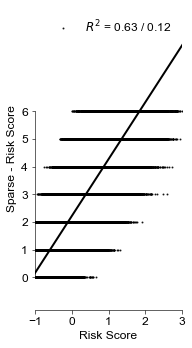

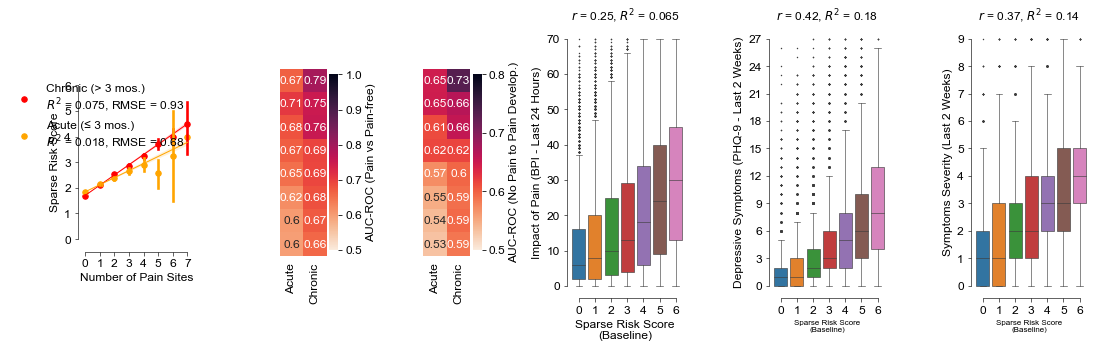

In [96]:
#### Plotting the AUC-ROC Curve

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5,5), gridspec_kw={'width_ratios': [1], 'height_ratios': [1]})
# Figure Train: Correlation with Number of Pain Sites
sns.regplot(ax = axs, data = Raw_T0, ci = None,  x = 'PLS', y = 'Sparse_PLS', label = '$R^2$ = 0.63 / 0.12', color = 'k', scatter_kws={'s':1}, line_kws={'linewidth':2})
axs.set_aspect(0.75)
axs.spines[['right', 'top']].set_visible(False), axs.tick_params(left=True, bottom=True), axs.legend(frameon=False, fontsize = 12)
axs.set_xlabel('Risk Score'), axs.set_ylabel('Sparse - Risk Score', fontsize = 12)
axs.set_xlim((-1, 3))
axs.set_xticks([-1, 0, 1, 2, 3]), axs.spines['bottom'].set_bounds((-1, 3))
axs.set_yticks([0, 1, 2, 3, 4, 5, 6]), axs.spines['left'].set_bounds((0, 6))
axs.spines[['bottom', 'left']].set_linewidth(0.6), axs.tick_params(width = 0.6)
fig.tight_layout()
fig.show()

fig, axs = plt.subplots(ncols=6, nrows=1, figsize=(15,5), gridspec_kw={'width_ratios': [1,0.5,0.5, 1, 1,1], 'height_ratios': [1]})
## Figure Test: Correlation with Number of Pain Sites
sns.regplot(ax = axs[0], data = T2_noWP, n_boot=500,  x_estimator=np.mean, x = 'NumberChronicPainTypes_T0', y = 'Sparse_PLS', label = 'Chronic (> 3 mos.)\n$R^2$ = 0.075, RMSE = 0.93', color = 'Red', scatter_kws={'s':30}, line_kws={'linewidth':1})
sns.regplot(ax = axs[0], data = T2_noWP, n_boot=500,  x_estimator=np.mean, x = 'NumberAcutePainTypes_T0', y = 'Sparse_PLS', label = 'Acute (≤ 3 mos.)\n$R^2$ = 0.018, RMSE = 0.68', color = 'orange', scatter_kws={'s':30}, line_kws={'linewidth':1})
axs[0].set_aspect(1.75)
axs[0].set_xticks(np.arange(0,8))
axs[0].set_xlim(-0.5, 7.5), axs[0].spines['bottom'].set_bounds((0, 7))
axs[0].spines[['right', 'top']].set_visible(False), axs[0].tick_params(left=True, bottom=True), axs[0].legend(frameon=False, fontsize = 12)
axs[0].set_xlabel('Number of Pain Sites'), axs[0].set_ylabel('Sparse Risk Score', fontsize = 12)
axs[0].set_yticks([0, 1, 2, 3, 4, 5, 6])
axs[0].set_ylim(-0.5, 6.5), axs[0].spines['left'].set_bounds((0, 6))
axs[0].spines[['bottom', 'left']].set_linewidth(0.6), axs[0].tick_params(width = 0.6)
# Figure HeatMap
#sns.heatmap(ax = axs[0,2], data = pd.DataFrame(np.asarray(AUCROC_T0).T[::-1], index = S[::-1], columns = ['Chronic', 'Acute'])[['Acute', 'Chronic']], square = True, annot=True, fmt=".2", cmap = 'rocket_r', yticklabels=False, vmin = 0.5, vmax = 1.0, cbar = True, cbar_kws =  {'ticks' : [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'label': 'AUC-ROC (Pain vs Pain-free)'})
#axs[0,2].set_xticklabels(axs[0,2].get_xticklabels(), rotation = 90, fontsize = 12)
# Figure HeatMap
sns.heatmap(ax = axs[1], data = pd.DataFrame(np.asarray(AUCROC_T2).T[::-1], index = S[::-1], columns = ['Chronic', 'Acute'])[['Acute', 'Chronic']], square = True, cbar = True, annot=True, fmt=".2", cmap = 'rocket_r', yticklabels=False, vmin = 0.5, vmax = 1.0, cbar_kws =  {'ticks' : [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'label': 'AUC-ROC (Pain vs Pain-free)'})
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation = 90, fontsize = 12), axs[1].tick_params(bottom=False)
# Figure HeatMap
sns.heatmap(ax = axs[2], data = pd.DataFrame(np.asarray(L_AUCROC).T[::-1], index = S[::-1], columns = ['Chronic', 'Acute'])[['Acute', 'Chronic']], square = True, cbar = True, annot=True, fmt=".2", cmap = 'rocket_r', yticklabels=False, vmin = 0.5, vmax = 0.8, cbar_kws =  {'ticks' : [0.5, 0.6, 0.7, 0.8], 'label': 'AUC-ROC (No Pain to Pain Develop.)'})
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation = 90, fontsize = 12), axs[2].tick_params(bottom=False)
# Figure Impact of Pain
sns.boxplot(ax = axs[3], data = Pain_Exp_TT, x = 'Sparse_PLS', y = 'Impact', linewidth=0.6, fliersize=0.6)
axs[3].spines[['right', 'top']].set_visible(False), axs[3].spines['left'].set_bounds((0, 70)), axs[3].spines['bottom'].set_bounds((0, 6))
axs[3].set_xlim((-0.75, 6.5)), axs[3].set_xticklabels([0, 1, 2, 3, 4, 5, 6]), axs[3].set_xlabel('Sparse Risk Score\n(Baseline)', fontsize = 12)
axs[3].set_ylabel('Impact of Pain (BPI - Last 24 Hours)')
axs[3].set_title('$r$ = 0.25, $R^2$ = 0.065', fontsize = font)
axs[3].spines[['bottom', 'left']].set_linewidth(0.6), axs[3].tick_params(width = 0.6)
# Figure Depressed
sns.boxplot(ax = axs[4], data = Pain_Exp_TT, x = 'Sparse_PLS', y = 'Depression', linewidth=0.6, fliersize=0.6)
axs[4].spines[['right', 'top']].set_visible(False), axs[4].spines['left'].set_bounds((0, 27)), axs[4].spines['bottom'].set_bounds((0, 6))
axs[4].set_xlim((-0.75, 6.5)), axs[4].set_yticks(np.arange(0,30,3)), axs[4].set_xticklabels([0, 1, 2, 3, 4, 5, 6]), axs[4].set_xlabel('Sparse Risk Score\n(Baseline)', fontsize = 8)
axs[4].set_ylabel('Depressive Symptoms (PHQ-9 - Last 2 Weeks)')
axs[4].set_title('$r$ = 0.42, $R^2$ = 0.18', fontsize = font)
axs[4].spines[['bottom', 'left']].set_linewidth(0.6), axs[4].tick_params(width = 0.6)
# Figure Impact of Pain
sns.boxplot(ax = axs[5], data = Pain_Exp_TT, x = 'Sparse_PLS', y = 'Widespread', linewidth=0.6, fliersize=0.6)
axs[5].spines[['right', 'top']].set_visible(False), axs[5].spines['left'].set_bounds((0, 9)), axs[5].spines['bottom'].set_bounds((0, 6))
axs[5].set_xlim((-0.75, 6.5)), axs[5].set_yticks(np.arange(0,10, 1)) ,axs[5].set_xticklabels([0, 1, 2, 3, 4, 5, 6]), axs[5].set_xlabel('Sparse Risk Score\n(Baseline)', fontsize = 8)
axs[5].set_ylabel('Symptoms Severity (Last 2 Weeks)')
axs[5].set_title('$r$ = 0.37, $R^2$ = 0.14', fontsize = font)
axs[5].spines[['bottom', 'left']].set_linewidth(0.6), axs[5].tick_params(width = 0.6)
fig.tight_layout()
fig.show()
